In [4]:
%%capture --no-display
import modisco
from modisco.visualization import viz_sequence
import json
import h5py
import numpy as np
import pandas as pd
import sklearn.cluster
import scipy.cluster.hierarchy
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os

In [5]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

In [ ]:
# Define parameters/fetch arguments
tf_name = os.environ["TFM_RESULTS_TF_NAME"]
fold = int(os.environ["TFM_RESULTS_FOLD"])
if "TFM_RESULTS_TASK_INDEX" in os.environ:
    task_index = int(os.environ["TFM_RESULTS_TASK_INDEX"])
else:
    task_index = None
    
print("TF name: %s" % tf_name)
print("Fold: %s" % fold)
print("Task index: %s" % task_index)

[Skip to results](#results)

In [7]:
# Define paths and constants
input_length, profile_length = 1346, 1000
shap_score_center_size = 400
profile_display_center_size = 400

base_path = "/users/amtseng/tfmodisco/"
data_path = os.path.join(base_path, "data/processed/ENCODE/")
labels_path = os.path.join(data_path, "labels/%s" % tf_name)
results_path = os.path.join(base_path, "results")

# Paths to saved predictions, DeepSHAP scores, and TF-MoDISco results
preds_path = os.path.join(results_path, "peak_predictions/{0}/{0}_peak_prediction_performance_fold{1}.h5".format(tf_name, fold))
if task_index is None:
    shap_scores_path = os.path.join(results_path, "shap_scores/{0}/{0}_shap_scores_fold{1}.h5".format(tf_name, fold))
    tfm_results_path = os.path.join(results_path, "tfmodisco/{0}/{0}_tfm_fold{1}.h5".format(tf_name, fold))
else:
    shap_scores_path = os.path.join(results_path, "shap_scores/{0}/{0}_shap_scores_fold{1}_task{2}.h5".format(tf_name, fold, task_index))
    tfm_results_path = os.path.join(results_path, "tfmodisco/{0}/{0}_tfm_fold{1}_task{2}.h5".format(tf_name, fold, task_index))
    
# Paths to original called peaks
all_peak_beds = sorted([item for item in os.listdir(labels_path) if item.endswith(".bed.gz")])
if task_index is None:
    peak_bed_paths = [os.path.join(labels_path, item) for item in all_peak_beds]
else:
    peak_bed_paths = [os.path.join(labels_path, all_peak_beds[task_index])]

### Helper functions

In [17]:
def import_shap_scores(shap_scores_path):
    """
    Imports the set of SHAP scores used for the TF-MoDISco run. The SHAP scores
    are not cut down to a centered size yet.
    Arguments:
        `shap_scores_path`: path to HDF5 containing SHAP scores used to run
            TF-MoDISco, in the same order
    Returns an N x I x 4 array of hypothetical scores, an N x I x 4 array of
    input sequences, and an N x 3 object array of corresponding coordinates.
    """
    with h5py.File(shap_scores_path, "r") as f:
        coords_chrom = f["coords_chrom"][:].astype(str)
        coords_start = f["coords_start"][:]
        coords_end = f["coords_end"][:]
        one_hot_seqs = f["input_seqs"][:]
        hyp_scores = f["hyp_scores"][:]
    
    coords = np.empty((len(coords_chrom), 3), dtype=object)
    coords[:, 0] = coords_chrom
    coords[:, 1] = coords_start
    coords[:, 2] = coords_end
    
    return hyp_scores, one_hot_seqs, coords

In [18]:
def import_profiles(preds_path):
    """
    Imports the set of profile predictions.
    Arguments:
        `preds_path`: path to predictions/performance metrics of the model
    Returns an M x T x O x 2 array of true profile counts, an M x T x O x 2
    array of predicted profile probabilities, and an M x 3 object array of
    corresponding coordinates.
    """
    with h5py.File(preds_path, "r") as f:
        fold_true_profs = f["predictions"]["true_profs"][:]
        fold_log_pred_profs = f["predictions"]["log_pred_profs"][:]
        
        coords = np.empty((len(fold_true_profs), 3), dtype=object)
        coords[:, 0] = f["coords"]["coords_chrom"][:].astype(str)
        coords[:, 1] = f["coords"]["coords_start"][:]
        coords[:, 2] = f["coords"]["coords_end"][:]
    
    return fold_true_profs, np.exp(fold_log_pred_profs), coords

In [10]:
def extract_profiles_and_coords(
    seqlets_arr, one_hot_seqs, true_profs, pred_profs, pred_coords, input_length,
    profile_length, input_center_cut_size, profile_center_cut_size, task_index=None
):
    """
    From the seqlets object of a TF-MoDISco pattern's seqlets and alignments,
    extracts the predicted and observed profiles of the model, as well as the
    set of coordinates for the seqlets.
    Arguments:
        `seqlets_arr`: a TF-MoDISco pattern's seqlets object array (N-array)
        `one_hot_seqs`: an N x I x 4 array of input sequences
        `true_profs`: an N x T x O x 2 array of true profile counts
        `pred_profs`: an N x T x O x 2 array of predicted profile probabilities
        `pred_coords`: an N x 3 object array of coordinates for the input sequence
            underlying the predictions
        `input_length`: length of original input sequences, I
        `profile_length`: length of profile predictions, O
        `input_center_cut_size`: centered cut size of SHAP scores used
        `profile_center_cut_size`: size to cut profiles to when returning them, P
        `task_index`: index of task to focus on for profiles; if None, returns
            profiles for all tasks
    Returns an N x (T or 1) x P x 2 array of true profile counts, an
    N x (T or 1) x P x 2 array of predicted profile probabilities, an N x Q x 4
    array of one-hot seqlet sequences, and an N x 3 object array of seqlet coordinates,
    where P is the profile cut size and Q is the seqlet length. Returned profiles are
    centered at the same center as the seqlets.
    Note that it is important that the seqlet indices match exactly with the indices
    out of the N. This should be the exact sequences in the original SHAP scores.
    """
    true_seqlet_profs, pred_seqlet_profs, seqlet_seqs, seqlet_coords = [], [], [], []
    
    def seqlet_coord_to_profile_coord(seqlet_coord):
        return seqlet_coord + ((input_length - input_center_cut_size) // 2) - ((input_length - profile_length) // 2)
    
    def seqlet_coord_to_input_coord(seqlet_coord):
        return seqlet_coord + ((input_length - input_center_cut_size) // 2)
        
    # For each seqlet, fetch the true/predicted profiles
    for seqlet in seqlets_arr:
        coord_index = seqlet.coor.example_idx
        seqlet_start = seqlet.coor.start
        seqlet_end = seqlet.coor.end
        seqlet_rc = seqlet.coor.is_revcomp
        
        # Get indices of profile to cut out
        seqlet_center = (seqlet_start + seqlet_end) // 2
        prof_center = seqlet_coord_to_profile_coord(seqlet_center)
        prof_start = prof_center - (profile_center_cut_size // 2)
        prof_end = prof_start + profile_center_cut_size
        
        task_start, task_end = (task_index, task_index + 1) if task_index is not None else (None, None)
        true_prof = true_profs[coord_index, task_start:task_end, prof_start:prof_end]  # (T or 1) x P x 2
        pred_prof = pred_profs[coord_index, task_start:task_end, prof_start:prof_end]  # (T or 1) x P x 2
        true_seqlet_profs.append(true_prof)
        pred_seqlet_profs.append(pred_prof)
        
        # Get indices of input sequence corresponding to seqlet
        inp_start = seqlet_coord_to_input_coord(seqlet_start)
        inp_end = seqlet_coord_to_input_coord(seqlet_end)
        if seqlet_rc:
            seqlet_seqs.append(np.flip(one_hot_seqs[coord_index, inp_start:inp_end], axis=(0, 1)))
        else:
            seqlet_seqs.append(one_hot_seqs[coord_index, inp_start:inp_end])
            
        # Get the coordinates of the seqlet based on the input coordinates
        chrom, start, _ = pred_coords[coord_index]
        seqlet_coords.append([chrom, start + inp_start, start + inp_end])
    
    return np.stack(true_seqlet_profs), np.stack(pred_seqlet_profs), np.stack(seqlet_seqs), np.array(seqlet_coords, dtype=object)

In [28]:
def import_tfmodisco_results(tfm_results_path, hyp_scores, one_hot_seqs, input_center_cut_size):
    """
    Imports the TF-MoDISco results object.
    Arguments:
        `tfm_results_path`: path to HDF5 containing TF-MoDISco results
        `hyp_scores`: hypothetical importance scores used for this run
        `one_hot_seqs`: input sequences used for this run
        `input_center_cut_size`: centered cut size of SHAP scores used
    """ 
    # Cut everything to `input_center_cut_size`
    seq_len = one_hot_seqs.shape[1]
    start = (seq_len // 2) - (input_center_cut_size // 2)
    end = start + input_center_cut_size
    one_hot_seqs = one_hot_seqs[:, start:end]
    hyp_scores = hyp_scores[:, start:end]
    act_scores = hyp_scores * one_hot_seqs
    
    track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
        task_names=["task0"],
        contrib_scores={"task0": act_scores},
        hypothetical_contribs={"task0": hyp_scores},
        one_hot=one_hot_seqs
    )
    
    with h5py.File(tfm_results_path,"r") as f:
        return modisco.tfmodisco_workflow.workflow.TfModiscoResults.from_hdf5(f, track_set=track_set)

In [12]:
def plot_profiles(seqlet_true_profs, seqlet_pred_profs, kmeans_clusters=5):
    """
    Plots the given profiles with a heatmap.
    Arguments:
        `seqlet_true_profs`: an N x O x 2 NumPy array of true profiles, either as raw
            counts or probabilities (they will be normalized)
        `seqlet_pred_profs`: an N x O x 2 NumPy array of predicted profiles, either as
            raw counts or probabilities (they will be normalized)
        `kmeans_cluster`: when displaying profile heatmaps, there will be this
            many clusters
    """
    assert len(seqlet_true_profs.shape) == 3
    assert seqlet_true_profs.shape == seqlet_pred_profs.shape
    num_profs, width, _ = seqlet_true_profs.shape

    # First, normalize the profiles along the output profile dimension
    def normalize(arr, axis=0):
        arr_sum = np.sum(arr, axis=axis, keepdims=True)
        arr_sum[arr_sum == 0] = 1  # If 0, keep 0 as the quotient instead of dividing by 0
        return arr / arr_sum
    true_profs_norm = normalize(seqlet_true_profs, axis=1)
    pred_profs_norm = normalize(seqlet_pred_profs, axis=1)

    # Compute the mean profiles across all examples
    true_profs_mean = np.mean(true_profs_norm, axis=0)
    pred_profs_mean = np.mean(pred_profs_norm, axis=0)

    # Perform k-means clustering on the predicted profiles, with the strands pooled
    kmeans_clusters = max(5, num_profs // 50)  # Set number of clusters based on number of profiles, with minimum
    kmeans = sklearn.cluster.KMeans(n_clusters=kmeans_clusters)
    cluster_assignments = kmeans.fit_predict(
        np.reshape(pred_profs_norm, (pred_profs_norm.shape[0], -1))
    )

    # Perform hierarchical clustering on the cluster centers to determine optimal ordering
    kmeans_centers = kmeans.cluster_centers_
    cluster_order = scipy.cluster.hierarchy.leaves_list(
        scipy.cluster.hierarchy.optimal_leaf_ordering(
            scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid"), kmeans_centers
        )
    )

    # Order the profiles so that the cluster assignments follow the optimal ordering
    cluster_inds = []
    for cluster_id in cluster_order:
        cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
    cluster_inds = np.concatenate(cluster_inds)

    # Compute a matrix of profiles, normalized to the maximum height, ordered by clusters
    def make_profile_matrix(flat_profs, order_inds):
        matrix = flat_profs[order_inds]
        maxes = np.max(matrix, axis=1, keepdims=True)
        maxes[maxes == 0] = 1  # If 0, keep 0 as the quotient instead of dividing by 0
        return matrix / maxes
    true_matrix = make_profile_matrix(true_profs_norm, cluster_inds)
    pred_matrix = make_profile_matrix(pred_profs_norm, cluster_inds)

    # Create a figure with the right dimensions
    mean_height = 4
    heatmap_height = num_profs * 0.004
    fig_height = mean_height + (2 * heatmap_height)
    fig, ax = plt.subplots(
        3, 2, figsize=(16, fig_height), sharex=True,
        gridspec_kw={
            "width_ratios": [1, 1],
            "height_ratios": [mean_height / fig_height, heatmap_height / fig_height, heatmap_height / fig_height]
        }
    )

    # Plot the average predictions
    ax[0, 0].plot(true_profs_mean[:, 0], color="darkslateblue")
    ax[0, 0].plot(-true_profs_mean[:, 1], color="darkorange")
    ax[0, 1].plot(pred_profs_mean[:, 0], color="darkslateblue")
    ax[0, 1].plot(-pred_profs_mean[:, 1], color="darkorange")

    # Set axes on average predictions
    max_mean_val = max(np.max(true_profs_mean), np.max(pred_profs_mean))
    mean_ylim = max_mean_val * 1.05  # Make 5% higher
    ax[0, 0].set_title("True profiles")
    ax[0, 0].set_ylabel("Average probability")
    ax[0, 1].set_title("Predicted profiles")
    for j in (0, 1):
        ax[0, j].set_ylim(-mean_ylim, mean_ylim)
        ax[0, j].label_outer()

    # Plot the heatmaps
    ax[1, 0].imshow(true_matrix[:, :, 0], interpolation="nearest", aspect="auto", cmap="Blues")
    ax[1, 1].imshow(pred_matrix[:, :, 0], interpolation="nearest", aspect="auto", cmap="Blues")
    ax[2, 0].imshow(true_matrix[:, :, 1], interpolation="nearest", aspect="auto", cmap="Oranges")
    ax[2, 1].imshow(pred_matrix[:, :, 1], interpolation="nearest", aspect="auto", cmap="Oranges")

    # Set axes on heatmaps
    for i in (1, 2):
        for j in (0, 1):
            ax[i, j].set_yticks([])
            ax[i, j].set_yticklabels([])
            ax[i, j].label_outer()
    width = true_matrix.shape[1]
    delta = 100
    num_deltas = (width // 2) // delta
    labels = list(range(max(-width // 2, -num_deltas * delta), min(width // 2, num_deltas * delta) + 1, delta))
    tick_locs = [label + max(width // 2, num_deltas * delta) for label in labels]
    for j in (0, 1):
        ax[2, j].set_xticks(tick_locs)
        ax[2, j].set_xticklabels(labels)
        ax[2, j].set_xlabel("Distance from peak summit (bp)")

    fig.tight_layout()
    plt.show()

In [13]:
def import_peak_table(peak_bed_paths):
    tables = []
    for peak_bed_path in peak_bed_paths:
        table = pd.read_csv(
            peak_bed_path, sep="\t", names=[
                "chrom", "start", "end", "peak_start", "peak_end", "summit"
            ]
        )
        tables.append(table)
    return pd.concat(tables)

In [15]:
def get_summit_distances(coords, peak_table):
    """
    Given a set of coordinates, computes the distance of the center of each
    coordinate to the nearest summit.
    Arguments:
        `coords`: an N x 3 object array of coordinates
        `peak_table`: a 6-column table of peak data, as imported by
            `import_peak_table`
    Returns and N-array of integers, which is the distance of each coordinate
    midpoint to the nearest coordinate.
    """
    chroms = coords[:, 0]
    midpoints = (coords[:, 1] + coords[:, 2]) // 2
    dists = []
    for i in range(len(coords)):
        chrom = chroms[i]
        midpoint = midpoints[i]
        rows = peak_table[peak_table["chrom"] == chrom]
        dist_arr = (midpoint - rows["summit"]).values
        min_dist = dist_arr[np.argmin(np.abs(dist_arr))]
        dists.append(min_dist)
    return np.array(dists)

In [16]:
def plot_summit_dists(summit_dists):
    """
    Plots the distribution of seqlet distances to summits.
    Arguments:
        `summit_dists`: the array of distances as returned by
            `get_summit_distances`
    """
    plt.figure(figsize=(8, 6))
    num_bins = max(len(summit_dists) // 30, 20)
    plt.hist(summit_dists, bins=num_bins, color="purple")
    plt.title("Histogram of distance of seqlets to peak summits")
    plt.xlabel("Signed distance from seqlet center to nearest peak summit (bp)")
    plt.show()

### Import SHAP scores and profile predictions

In [ ]:
# Import SHAP coordinates and one-hot sequences
hyp_scores, one_hot_seqs, shap_coords = import_shap_scores(shap_scores_path)

# Import the set of all profiles and their coordinates
true_profs, pred_profs, pred_coords = import_profiles(preds_path)

# Make sure the coordinates all match
assert np.all(pred_coords == shap_coords)

# Import the set of peaks
peak_table = import_peak_table(peak_bed_paths)

<a id="results"></a>
### Plot some SHAP score tracks
Plot the central region of some randomly selected actual importance scores

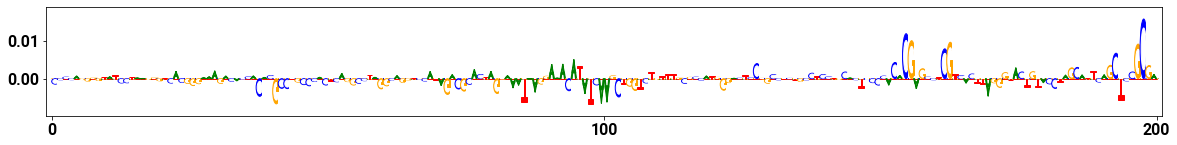

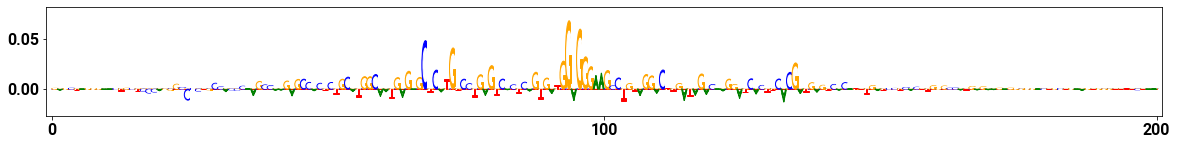

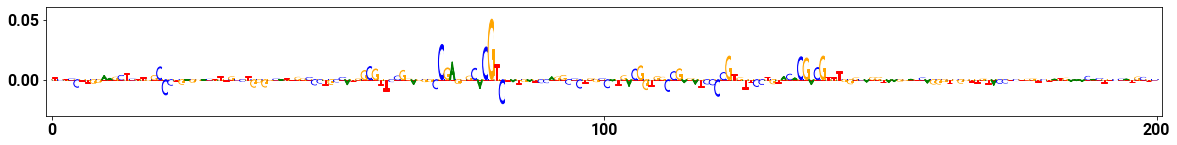

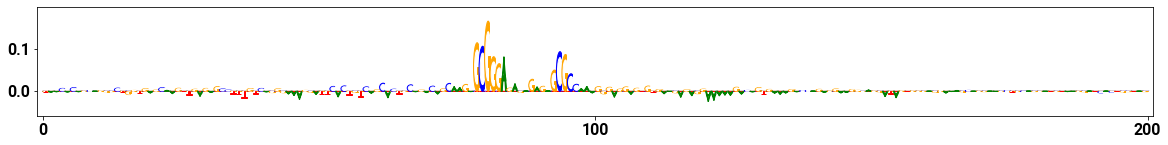

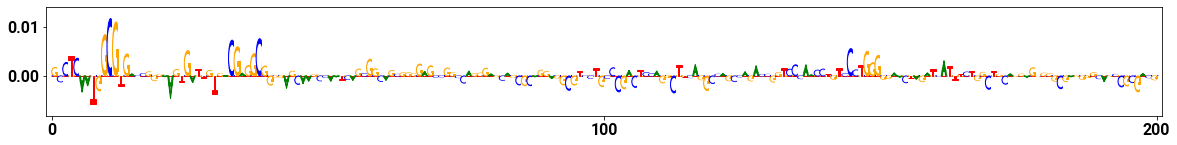

In [25]:
for index in np.random.choice(hyp_scores.shape[0], size=5, replace=False):
    viz_sequence.plot_weights((hyp_scores[index] * one_hot_seqs[index])[600:800], subticks_frequency=100)

### Import and plot TF-MoDISco results
Plot all motifs by metacluster

In [29]:
# Import the TF-MoDISco results object
tfm_obj = import_tfmodisco_results(tfm_results_path, hyp_scores, one_hot_seqs, shap_score_center_size)

Metacluster 1/2
Pattern 1/10
--------------------------------------
2545 seqlets
Sequence


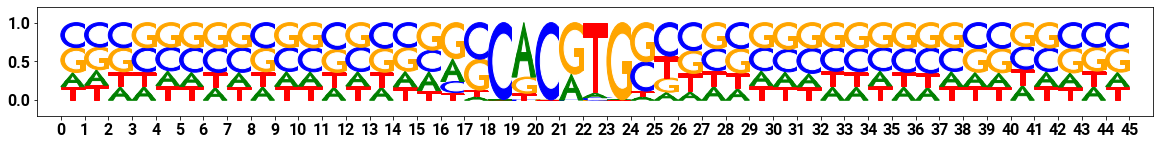

Hypothetical contributions


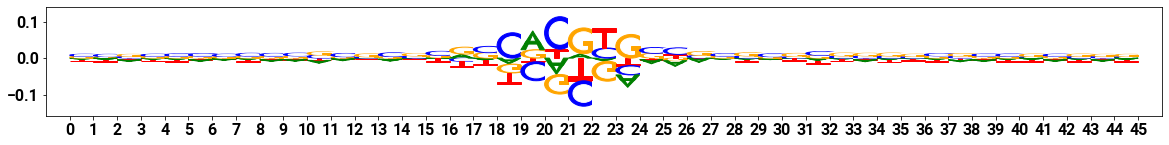

Contribution_scores


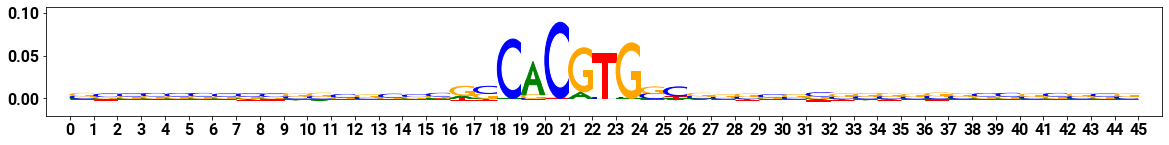

Predicted/observed profiles


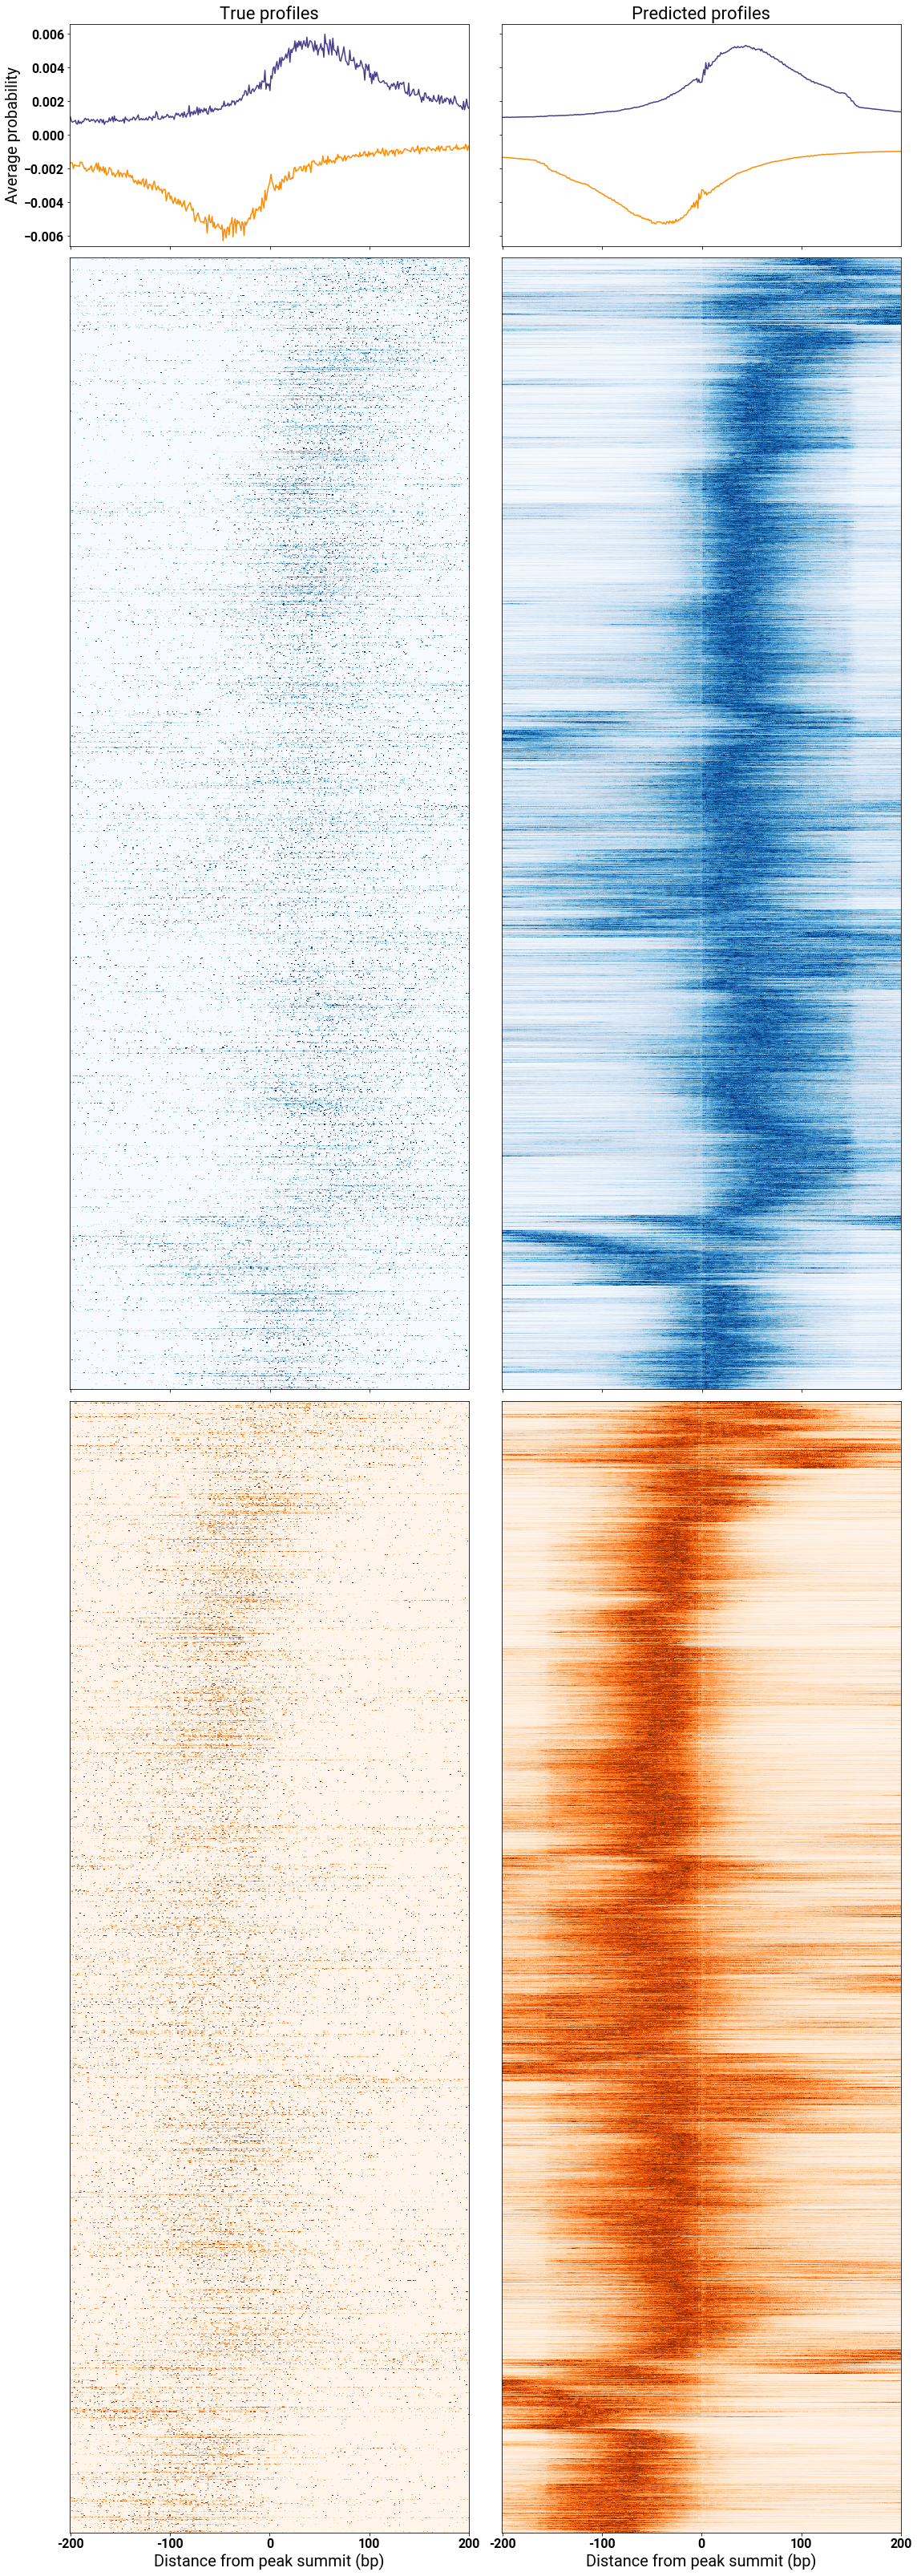

Seqlet distance from summits


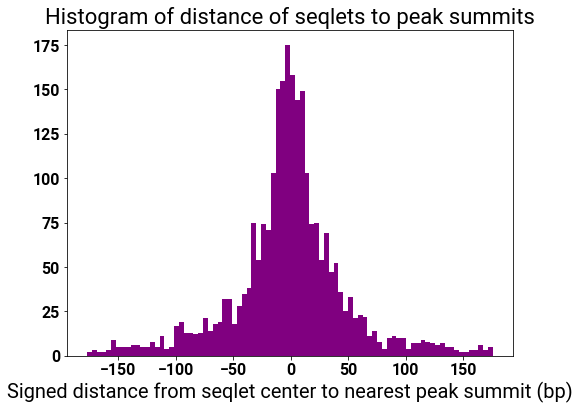

Pattern 2/10
--------------------------------------
1637 seqlets
Sequence


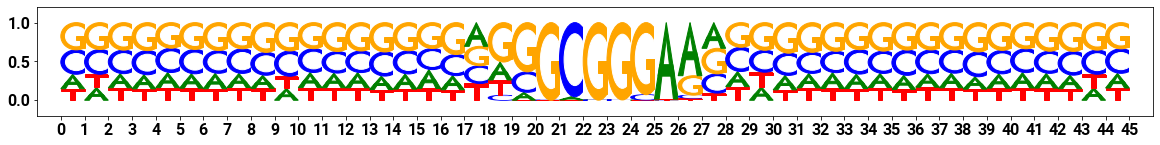

Hypothetical contributions


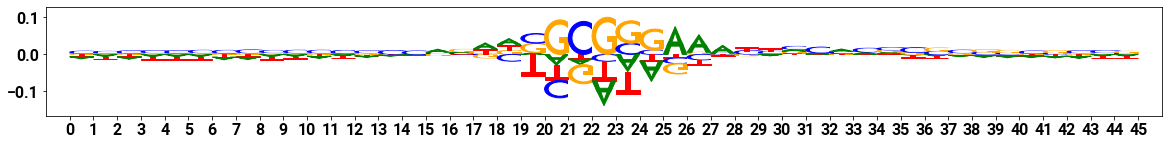

Contribution_scores


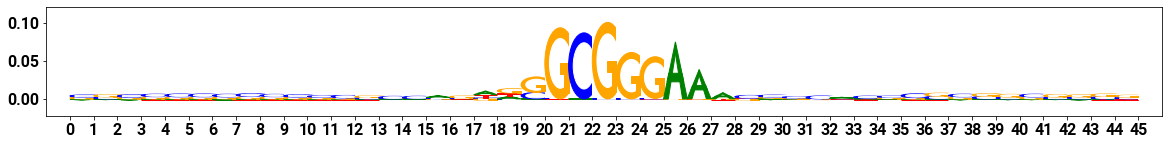

Predicted/observed profiles


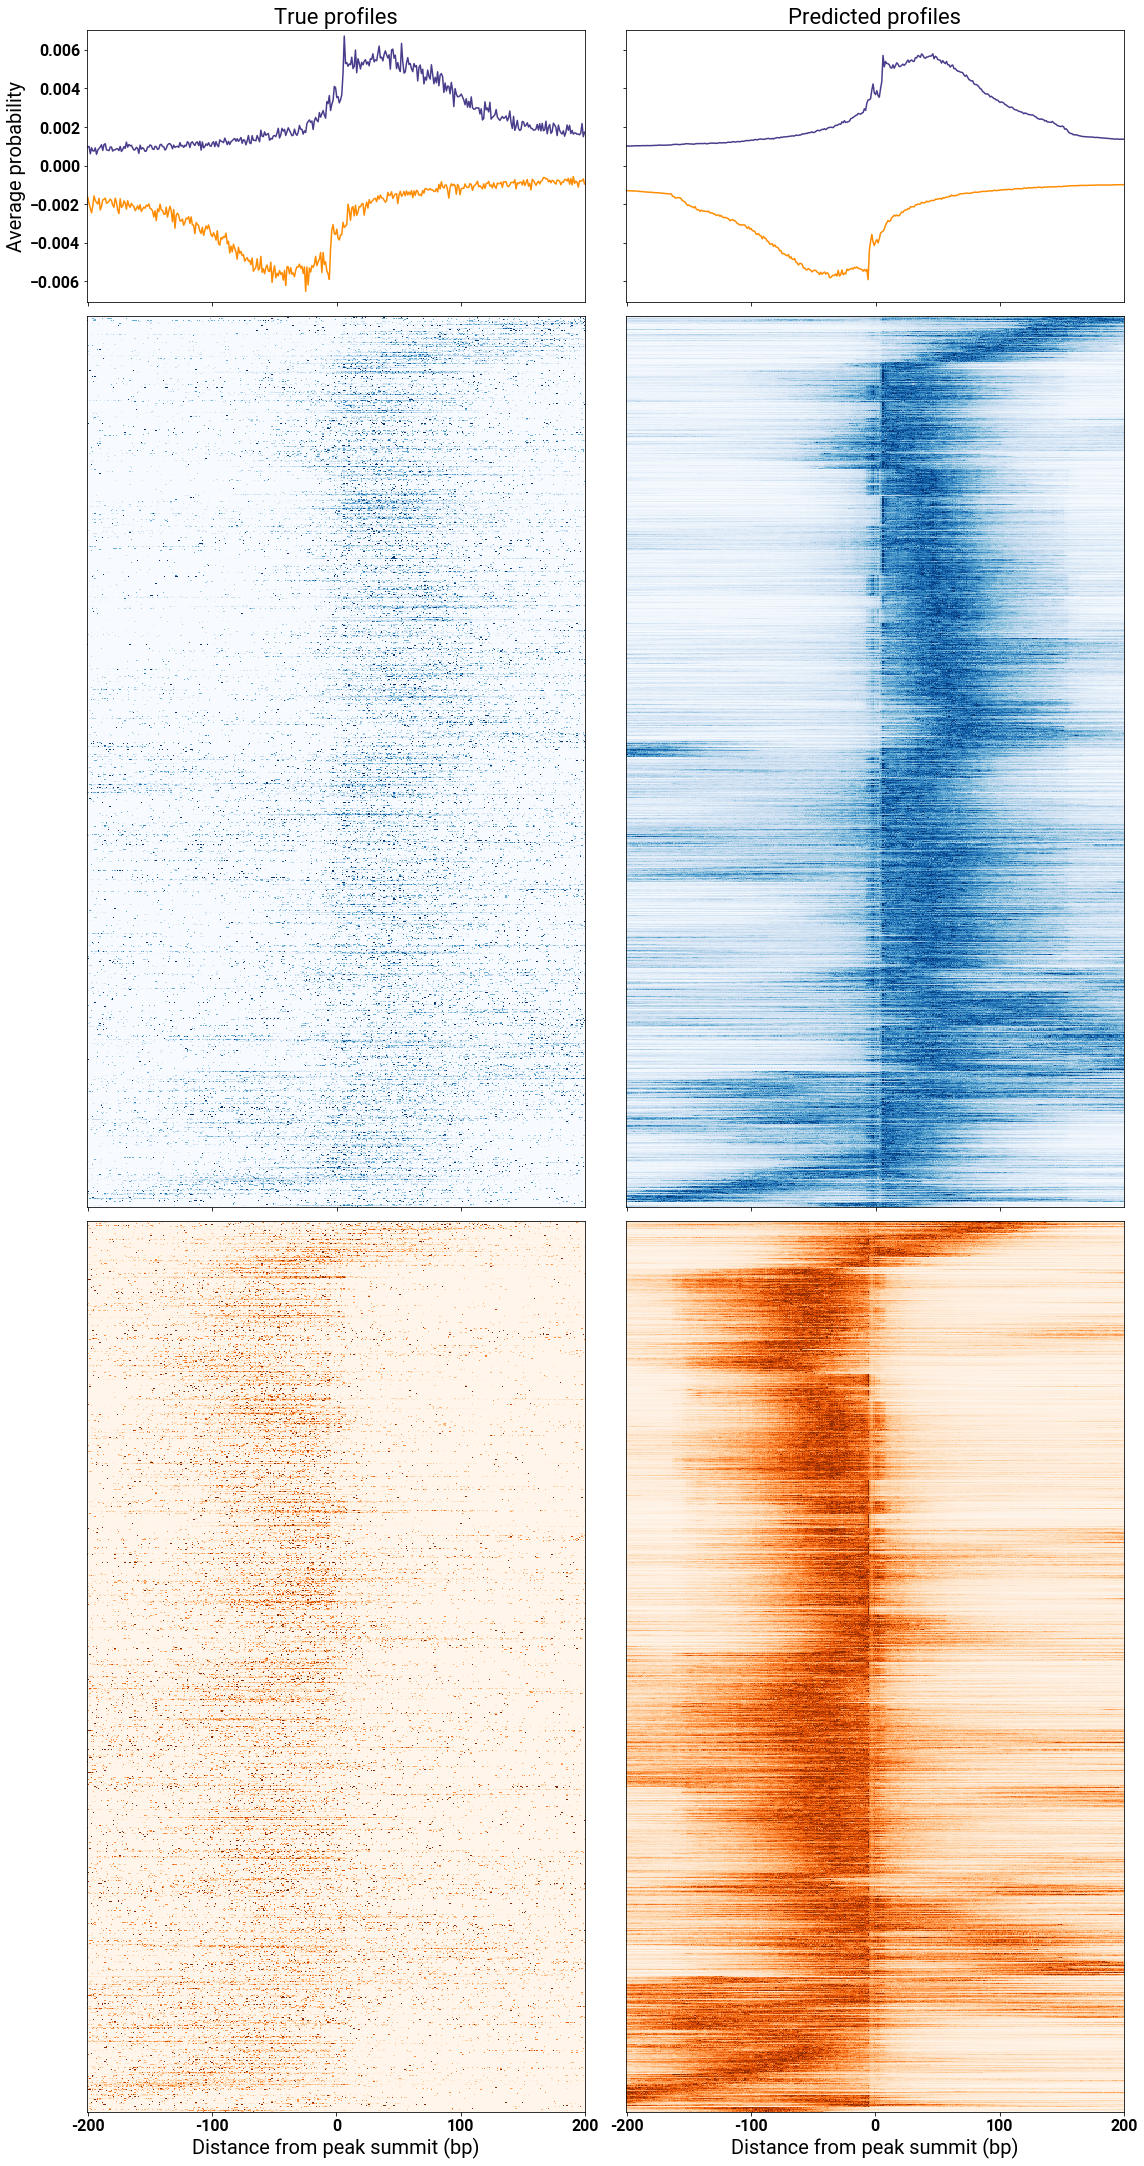

Seqlet distance from summits


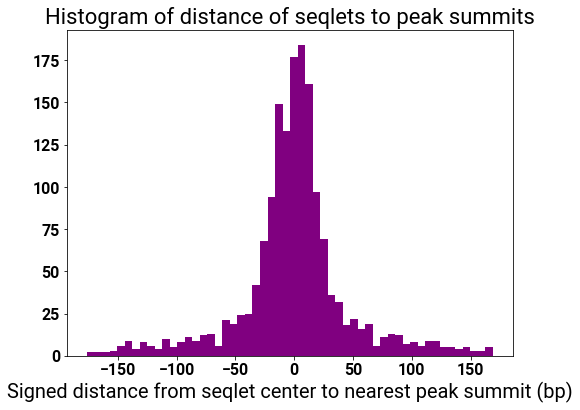

Pattern 3/10
--------------------------------------
711 seqlets
Sequence


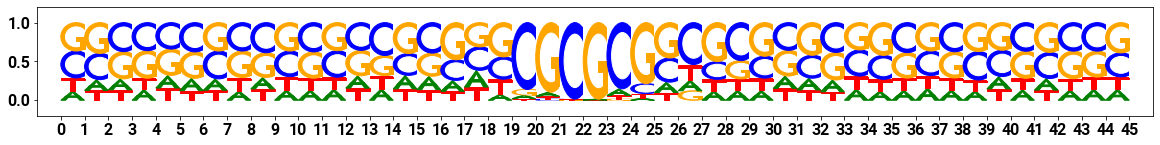

Hypothetical contributions


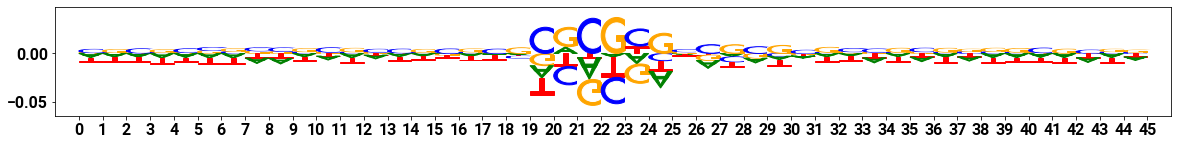

Contribution_scores


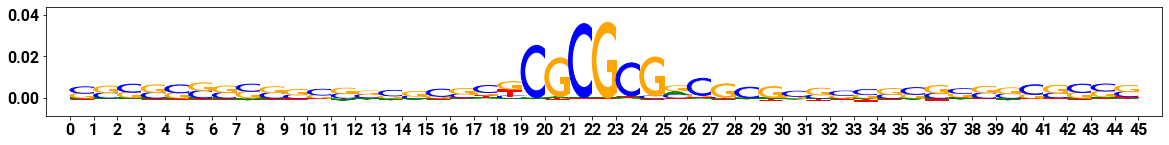

Predicted/observed profiles


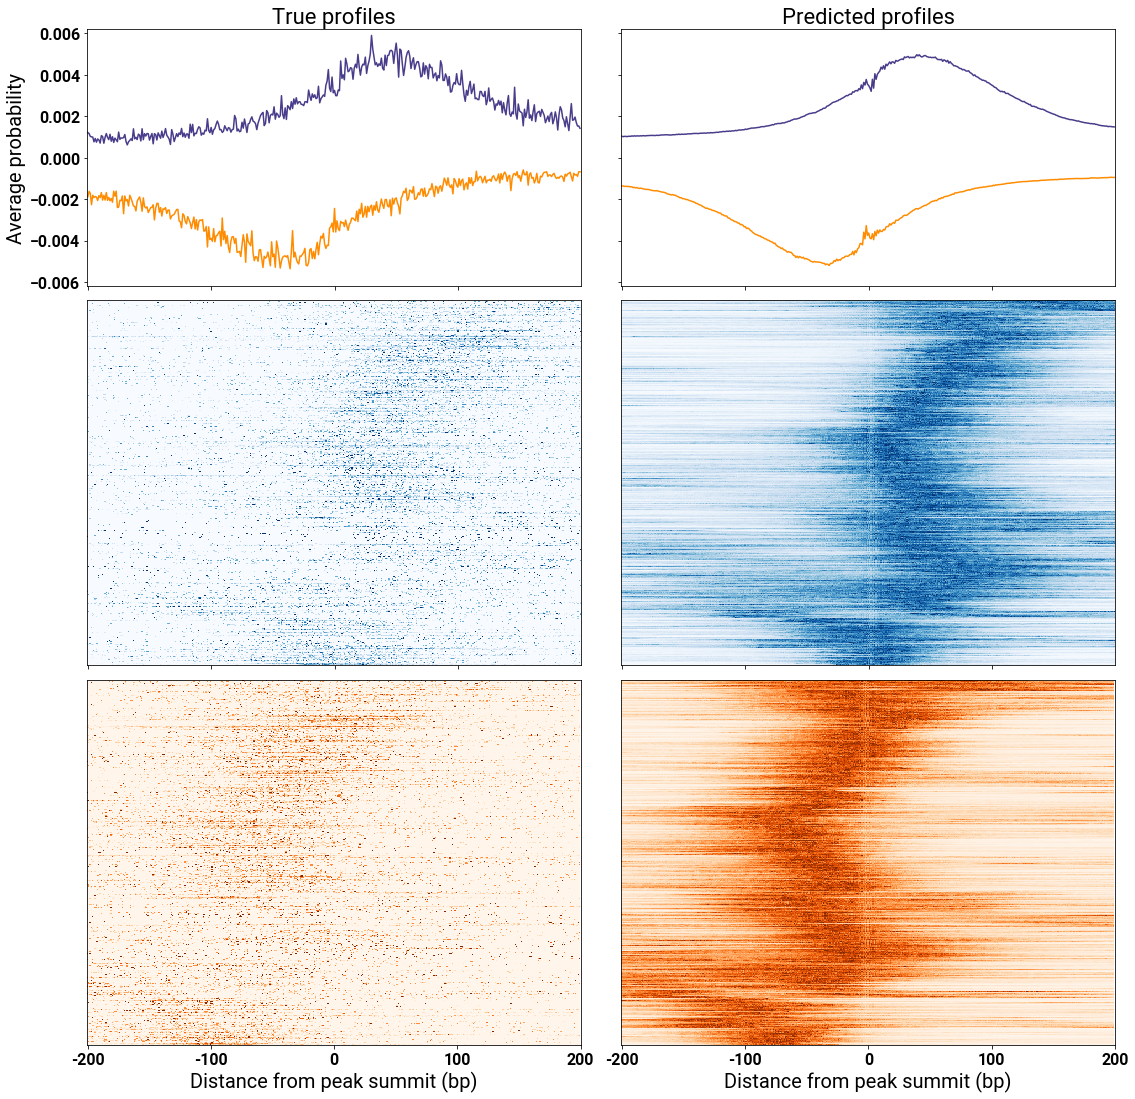

Seqlet distance from summits


KeyboardInterrupt: 

In [30]:
metaclusters = tfm_obj.metacluster_idx_to_submetacluster_results
num_metaclusters = len(metaclusters.keys())
for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
    metacluster = metaclusters[metacluster_key]
    print("Metacluster %d/%d" % (metacluster_i + 1, num_metaclusters))
    print("==========================================")
    patterns = metacluster.seqlets_to_patterns_result.patterns
    if not patterns:
        break
    num_patterns = len(patterns)
    for pattern_i, pattern in enumerate(patterns):
        seqlets = pattern.seqlets
        print("Pattern %d/%d" % (pattern_i + 1, num_patterns))
        print("--------------------------------------")

        print("%d seqlets" % len(seqlets))
        print("Sequence")
        viz_sequence.plot_weights(pattern["sequence"].fwd)
        print("Hypothetical contributions")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)
        print("Contribution_scores")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
        
        seqlet_true_profs, seqlet_pred_profs, seqlet_seqs, seqlet_coords = extract_profiles_and_coords(
            seqlets, one_hot_seqs, true_profs, pred_profs, pred_coords, input_length,
            profile_length, shap_score_center_size, profile_display_center_size,
            task_index=task_index
        )

        assert np.all(np.sum(seqlet_seqs, axis=0) / len(seqlet_seqs) == pattern["sequence"].fwd)
        # ^Sanity check: PFM derived from seqlets match the PFM stored in the pattern
        print("Predicted/observed profiles")
        plot_profiles(
            # Flatten to NT x O x 2
            np.reshape(seqlet_true_profs, (-1, seqlet_true_profs.shape[2], seqlet_true_profs.shape[3])),
            np.reshape(seqlet_pred_profs, (-1, seqlet_pred_profs.shape[2], seqlet_pred_profs.shape[3]))
        )
        
        print("Seqlet distance from summits")
        summit_dists = get_summit_distances(seqlet_coords, peak_table)
        plot_summit_dists(summit_dists)